In [1]:
import pandas as pd #data manipulation
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score 
# 1. Load data
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In [2]:
#cleaning data 
# Handle missing age values 
train_data_clean = train_data.copy()
test_data_clean = test_data.copy()
# Fill missing Age with median (middle value)
train_data_clean['Age'] = train_data_clean['Age'].fillna(train_data['Age'].median())
test_data_clean['Age'] = test_data_clean['Age'].fillna(test_data['Age'].median())

train_data_clean['IsFemale'] = train_data_clean['Sex'].apply(lambda x : 1 if x == "female" else 0)
test_data_clean['IsFemale'] = test_data_clean['Sex'].apply(lambda x : 1 if x == "female" else 0)

train_data_clean['Name_length'] = train_data_clean['Name'].apply(lambda x: len(x))
test_data_clean['Name_length']  = test_data_clean['Name'].apply(lambda x: len(x))

train_data_clean['Family_size'] = train_data_clean['Parch'] + train_data_clean['SibSp'] +1
test_data_clean['Family_size'] = test_data_clean['Parch'] + test_data_clean['SibSp'] +1

In [3]:
def family_group(size):
    if size == 1:
        return "Alone"
    elif 2 <= size <= 4:
        return "Small"
    else:
        return "Large"

train_data_clean["FamilyGroup"] = train_data_clean["Family_size"].apply(family_group)
test_data_clean["FamilyGroup"]  = test_data_clean["Family_size"].apply(family_group)
test_data_clean.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,IsFemale,Name_length,Family_size,FamilyGroup
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,16,1,Alone
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,32,2,Small
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,25,1,Alone
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,16,1,Alone
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,44,3,Small


In [4]:
train_data_clean['Sex_Embarked'] = (
    train_data_clean['Sex'] + "_" +
    train_data_clean['Embarked']
)

test_data_clean['Sex_Embarked'] = (
    test_data_clean['Sex'] + "_" +
    test_data_clean['Embarked']
)
train_data_clean['Sex_Pclass'] = (
    train_data_clean['Sex'] + "_" + 
    train_data_clean['Pclass'].astype(str)
)
test_data_clean['Sex_Pclass'] = (
    test_data_clean['Sex'] + "_" +
    test_data_clean['Pclass'].astype(str)
)

In [5]:
#Name Length Group
# Step 1: create bins
bins = [0,10,20,30,40,50,60,70,80]

# Step 2: create labels
labels = ['0-10','11-20','21-30','31-40',
          '41-50','51-60','61-70','71-80']

# Step 3: group the values
train_data_clean['Name_group'] = pd.cut(
    train_data_clean['Name_length'],
    bins=bins,
    labels=labels,
    right=True,        # includes the right edge
    include_lowest=True
)
test_data_clean['Name_group'] = pd.cut(
    test_data_clean['Name_length'],
    bins=bins,
    labels=labels,
    right=True,        # includes the right edge
    include_lowest=True
)

In [6]:
#Social Status Feature
train_data_clean["social_status"] = (
    train_data_clean["Name"]
    .str.split(",").str[1]   
    .str.split(".").str[0]      
    .str.strip()               
)
test_data_clean["social_status"] = (
    test_data_clean["Name"]
    .str.split(",").str[1]   
    .str.split(".").str[0]      
    .str.strip()               
)

In [7]:
# 2. Prepare features and target
y = train_data["Survived"]  # What we want to predict
features = ["Pclass", "IsFemale", "SibSp", "Parch","Embarked","Age","FamilyGroup","Name_group","social_status"]
# 2. Prepare features and target
y = train_data["Survived"]  # What we want to predict
X_train = pd.get_dummies(train_data_clean[features])  # Convert categorical features to numbers
X_test = pd.get_dummies(test_data_clean[features])  # Same for test data

In [8]:
from sklearn.feature_selection import RFE

model = RandomForestClassifier(n_estimators=100,max_depth=7,random_state=0)
rfe = RFE(model, n_features_to_select=12)  # pick top 12 features
rfe.fit(X_train, y)
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['Pclass', 'IsFemale', 'SibSp', 'Parch', 'Age', 'Embarked_S',
       'FamilyGroup_Large', 'FamilyGroup_Small', 'Name_group_41-50',
       'social_status_Miss', 'social_status_Mr', 'social_status_Mrs'],
      dtype='object')


In [9]:
#To Ensure that bot test and train df have the same columns 
#Exemple: (['social_status_Mlle'] not in index) in the test df
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


In [10]:
data = X_train.copy()
data['Survived'] = y
corr_target = data.corr()['Survived'].abs().sort_values()
#strong correlated features to target
strong_features = corr_target[(corr_target >= 0.05) & (corr_target != 1)].index.tolist()
#X_train_strong = X_train[strong_features]
#X_test_strong  = X_test[strong_features]

#print("strong Features:",strong_features)

#RFE features
X_train_strong = X_train[selected_features]
X_test_strong  = X_test[selected_features]
print("Selected Features:",selected_features)

#Raw Features
##X_train_strong = X_train
#X_test_strong = X_test

#print("Features:",features)

Selected Features: Index(['Pclass', 'IsFemale', 'SibSp', 'Parch', 'Age', 'Embarked_S',
       'FamilyGroup_Large', 'FamilyGroup_Small', 'Name_group_41-50',
       'social_status_Miss', 'social_status_Mr', 'social_status_Mrs'],
      dtype='object')


In [11]:
from sklearn.model_selection import train_test_split
#split data
train_X, val_X,train_y,val_y= train_test_split(X_train_strong,y,random_state=0)
train_X.head()

,Pclass,IsFemale,SibSp,Parch,Age,Embarked_S,FamilyGroup_Large,FamilyGroup_Small,Name_group_41-50,social_status_Miss,social_status_Mr,social_status_Mrs
105,3,0,0,0,28.0,True,False,False,False,False,True,False
68,3,1,4,2,17.0,True,True,False,False,True,False,False
253,3,0,1,0,30.0,True,False,True,False,False,True,False
320,3,0,0,0,22.0,True,False,False,False,False,True,False
706,2,1,0,0,45.0,True,False,False,False,False,False,True


In [12]:
def best_depth():
    best = 0 
    best_accuracy = 0
    for i in range(1,12):
        model = RandomForestClassifier(n_estimators=100,max_depth=i,random_state=0)
        model.fit(train_X,train_y)
        train_predictions = model.predict(val_X)  
        accuracy = accuracy_score(val_y, train_predictions) 
        if(best_accuracy<accuracy):
            best = i
            best_accuracy=accuracy

    return best
print(best_depth())

7


In [13]:
model = RandomForestClassifier(n_estimators=100,max_depth=best_depth(),random_state=0)
model.fit(train_X,train_y)
train_predictions = model.predict(val_X)  
accuracy = accuracy_score(val_y, train_predictions) 
accuracy

0.8161434977578476

In [14]:
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier(n_estimators=100,max_depth=best_depth(),random_state=0)
rf_cv = cross_val_score(model, train_X, train_y, cv=5)  
print("Scores for each fold:", rf_cv)
print("Mean CV score:", rf_cv.mean())


Scores for each fold: [0.82835821 0.8358209  0.82835821 0.81203008 0.86466165]
Mean CV score: 0.8338458085512288


In [15]:
# # 3. Create and train model

# final_model = RandomForestClassifier(n_estimators=100,max_depth=best_depth(),random_state=0)
# final_model.fit(X_train_strong, y)  # Train on ALL training data
# # 4. Make predictions on test data
# predictions = final_model.predict(X_test_strong)                 
# # 5. Save for submission
# output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
# output.to_csv('submission.csv', index=False)
# print ("success")

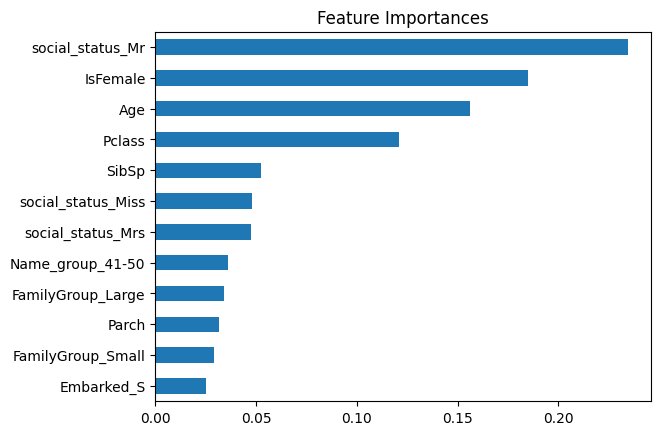

In [16]:
import matplotlib.pyplot as plt
model.fit(train_X, train_y)

feature_importances = pd.Series(model.feature_importances_, index=train_X.columns)
feature_importances.sort_values().plot(kind='barh')
plt.title("Feature Importances")
plt.show()

**Fine Tune XGB**

In [17]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import numpy as np

In [18]:
from xgboost import XGBClassifier
#define xgb for the randomizedsearchcv
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
param_dist = {
    "n_estimators": [200, 300, 400, 500, 600],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1],
    "max_depth": [3, 4, 5, 6],
    "min_child_weight": [1, 2, 3, 4],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=50,                # number of random combinations
    scoring="accuracy",
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(train_X, train_y)
print("Best Score:", random_search.best_score_)
print("Best Params:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Score: 0.8398832903153405
Best Params: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}


In [19]:

xgb = XGBClassifier(
    subsample=1.0,
    n_estimators=500,
    min_child_weight=1,
    max_depth=5,
    learning_rate=0.1,
    gamma=0.2,
    colsample_bytree=1.0,
    random_state=42,
    eval_metric="logloss"
)

xgb.fit(train_X, train_y)

xgb_cv = cross_val_score(xgb, train_X, train_y, cv=5, scoring="accuracy")

print("RandomForest CV:", rf_cv.mean())
print("XGBoost CV:", xgb_cv.mean())

RandomForest CV: 0.8338458085512288
XGBoost CV: 0.8338570306362924


**XGB Submitting**

In [20]:
# 3. Create and train model

xgb.fit(X_train_strong, y)  # Train on ALL training data
# 4. Make predictions on test data
predictions = xgb.predict(X_test_strong)                 
# 5. Save for submission
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print ("success")

success
